## Imports de biblioteca e acesso ao Google Drive

In [1]:
pip install opencv-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import argparse
import os
import imutils
import time
import cv2
from imutils import paths

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.utils import to_categorical

In [4]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [5]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


## Montando o Dataset

In [6]:
!ls '/content/drive/MyDrive/IA/datasetBrain'

CroppedTesting	CroppedTraining  Testing  Training


In [7]:
# Hyperparemeters
INIT_LR = 1e-4
EPOCHS = 3
BS = 32

In [8]:
database_dir = '/content/drive/MyDrive/IA/datasetBrain'
train_dir = database_dir + '/CroppedTraining'
test_dir = database_dir + '/CroppedTesting'

CATEGORIES = ['no_tumor', 'yes_tumor']
data = []   # Imagens
labels = [] # Classes

In [9]:
for category in CATEGORIES:
  path = os.path.join(train_dir, category)
  for img in os.listdir(path):
    img_path = os.path.join(path, img)
    image = load_img(img_path, target_size = (224, 224))
    image = img_to_array(image)
    image = preprocess_input(image)

    data.append(image)
    labels.append(category)

In [10]:
# One-Hot Encoding
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

data = np.array(data, dtype = 'float32')
labels = np.array(labels)

In [11]:
(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size = 0.2, stratify = labels, random_state = 42)

In [12]:
aug = ImageDataGenerator(
    rotation_range = 20,
    zoom_range = 0.15,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.15,
    horizontal_flip = True,
    fill_mode = "nearest",
)

## Deep Learning

In [13]:
base_model = MobileNetV2(weights = "imagenet", include_top = False, input_tensor = Input(shape = (224, 224, 3)))

In [14]:
model_out = base_model.output
model_out = AveragePooling2D(pool_size = (7, 7)) (model_out)
model_out = Flatten(name = "Flatten") (model_out)
model_out = Dense(128, activation = "relu") (model_out)
model_out = Dropout(0.5) (model_out)
model_out = Dense(2, activation = "softmax") (model_out)

model = Model(inputs = base_model.input, outputs = model_out)

In [15]:
for layer in base_model.layers:
  layer.trainable = False

In [16]:
opt = Adam(lr = INIT_LR, decay = INIT_LR / EPOCHS)
model.compile(loss = "binary_crossentropy", optimizer = opt, metrics = ['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [17]:
H = model.fit(
    aug.flow(trainX, trainY, batch_size = BS),
    steps_per_epoch = len(trainX) // BS,
    validation_data = (testX, testY),
    validation_steps = len(testX) // BS,
    epochs = EPOCHS
)

Epoch 1/3
39/39 [==============================] - 58s 1s/step - loss: 0.3968 - accuracy: 0.8866 - val_loss: 0.2980 - val_accuracy: 0.9137
Epoch 2/3
39/39 [==============================] - 57s 1s/step - loss: 0.3226 - accuracy: 0.9137 - val_loss: 0.2715 - val_accuracy: 0.9137
Epoch 3/3
39/39 [==============================] - 54s 1s/step - loss: 0.2882 - accuracy: 0.9145 - val_loss: 0.2522 - val_accuracy: 0.9137


In [18]:
predIdxs = model.predict(testX, batch_size = BS)
predIdxs = np.argmax(predIdxs, axis = 1)

print(classification_report(testY.argmax(axis = 1), predIdxs, target_names = lb.classes_))

model.save("tumor_detector.model", save_format = "h5")

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

    no_tumor       0.91      1.00      0.95       286
   yes_tumor       0.00      0.00      0.00        27

    accuracy                           0.91       313
   macro avg       0.46      0.50      0.48       313
weighted avg       0.83      0.91      0.87       313



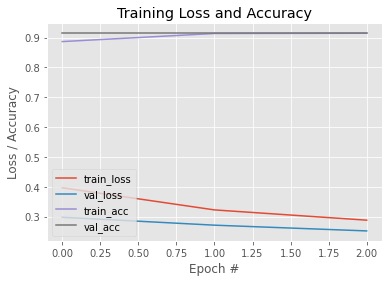

In [19]:
plt.style.use("ggplot")

plt.figure()
plt.plot(np.arange(0, EPOCHS), H.history['loss'], label = 'train_loss')
plt.plot(np.arange(0, EPOCHS), H.history['val_loss'], label = 'val_loss')
plt.plot(np.arange(0, EPOCHS), H.history['accuracy'], label = 'train_acc')
plt.plot(np.arange(0, EPOCHS), H.history['val_accuracy'], label = 'val_acc')

plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss / Accuracy")
plt.legend(loc = "lower left")

plt.savefig("tumor_detector_plot.png")

In [20]:
model = load_model("tumor_detector.model")

In [21]:
image = cv2.imread(test_dir + '/no_tumor/0.jpg')
img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (224, 224))
img = img_to_array(img)
img = preprocess_input(img)
img = np.expand_dims(img, axis = 0)

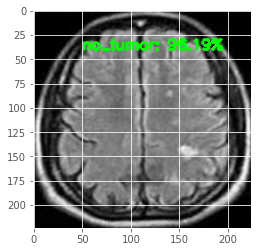

In [22]:
(no_tumor, yes_tumor) = model.predict(img)[0]

label = "no_tumor" if no_tumor > yes_tumor else "yes_tumor"
color = (0, 255, 0) if label == "no_tumor" else (0, 0, 255)
label = "{}: {:.2f}%".format(label, max(no_tumor, yes_tumor) * 100)

cv2.putText(image, label, (50, 50 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.show()